В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials

from sklearn.metrics import roc_auc_score
import xgboost as xgb

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [3]:
raw_df = pd.read_csv("train.csv")

raw_df = raw_df.drop(columns=["CustomerId", "Surname"])

categorical_cols = ["Geography", "Gender"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    raw_df[col] = le.fit_transform(raw_df[col])
    label_encoders[col] = le

def split_train_val(df, target_col, test_size=0.2, random_state=42):
    return train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])

target_col = "Exited"
train_df, val_df = split_train_val(raw_df, target_col)

input_cols = [col for col in raw_df.columns if col != target_col]
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf.fit(train_inputs, train_targets)
xgb_preds = xgb_clf.predict(val_inputs)
xgb_acc = accuracy_score(val_targets, xgb_preds)

lgb_clf = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_clf.fit(train_inputs, train_targets)
lgb_preds = lgb_clf.predict(val_inputs)
lgb_acc = accuracy_score(val_targets, lgb_preds)

def objective_xgb(params):
    clf = xgb.XGBClassifier(**params, random_state=42)
    clf.fit(train_inputs, train_targets)
    preds = clf.predict(val_inputs)
    return -accuracy_score(val_targets, preds)

space_xgb = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', [3, 5, 7]),
}

trials = Trials()
best_xgb = fmin(fn=objective_xgb, space=space_xgb, algo=tpe.suggest, max_evals=20, trials=trials)

print("XGBoost Accuracy:", xgb_acc)
print("LightGBM Accuracy:", lgb_acc)
print("Best XGBoost params:", best_xgb)


[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1096
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
100%|██████████| 20/20 [00:09<00:00,  2.04trial/s, best loss: -0.9]
XGBoost Accuracy: 0.8946666666666667
LightGBM Accuracy: 0.8963333333333333
Best XGBoost params: {'learning_rate': 0.19145472794096244, 'max_depth': 0, 'n_estimators': 1}


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [4]:
categorical_cols = ["Geography", "Gender"]

for col in categorical_cols:
    train_df[col] = pd.Categorical(train_df[col])
    val_df[col] = pd.Categorical(val_df[col])

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [5]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    tree_method='hist',
    enable_categorical=True,
    missing=np.nan,
    random_state=42
)

xgb_clf.fit(train_inputs, train_targets)

train_preds_proba = xgb_clf.predict_proba(train_inputs)[:, 1]
val_preds_proba = xgb_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds_proba)
val_auc = roc_auc_score(val_targets, val_preds_proba)

print("Train AUROC:", train_auc)
print("Validation AUROC:", val_auc)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train AUROC: 0.9730805964327622
Validation AUROC: 0.9316510048700184


**Висновки**

Баланс між bias і variance виглядає добре.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [6]:
space_xgb = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', [3, 5, 7]),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

def objective_xgb(params):
    clf = xgb.XGBClassifier(
        **params,
        use_label_encoder=False,
        tree_method='hist',
        enable_categorical=True,
        missing=np.nan,
        random_state=42
    )
    clf.fit(train_inputs, train_targets)
    preds_proba = clf.predict_proba(val_inputs)[:, 1]
    return -roc_auc_score(val_targets, preds_proba)

trials = Trials()
best_xgb = fmin(fn=objective_xgb, space=space_xgb, algo=tpe.suggest, max_evals=20, trials=trials)

print("Best Hyperparameters:", best_xgb)

final_clf = xgb.XGBClassifier(
    n_estimators=[50, 100, 200][best_xgb['n_estimators']],
    learning_rate=best_xgb['learning_rate'],
    max_depth=[3, 5, 7][best_xgb['max_depth']],
    subsample=best_xgb['subsample'],
    colsample_bytree=best_xgb['colsample_bytree'],
    use_label_encoder=False,
    tree_method='hist',
    enable_categorical=True,
    missing=np.nan,
    random_state=42
)
final_clf.fit(train_inputs, train_targets)

train_preds_proba = final_clf.predict_proba(train_inputs)[:, 1]
val_preds_proba = final_clf.predict_proba(val_inputs)[:, 1]
train_auc = roc_auc_score(train_targets, train_preds_proba)
val_auc = roc_auc_score(val_targets, val_preds_proba)

print("Train AUROC:", train_auc)
print("Validation AUROC:", val_auc)

  5%|▌         | 1/20 [00:00<00:03,  5.07trial/s, best loss: -0.9353467316002468]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:00<00:04,  4.48trial/s, best loss: -0.9353467316002468]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 4/20 [00:00<00:03,  4.67trial/s, best loss: -0.9353467316002468]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 6/20 [00:01<00:02,  4.69trial/s, best loss: -0.9353467316002468]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:01<00:02,  5.32trial/s, best loss: -0.9353467316002468]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:01<00:01,  5.86trial/s, best loss: -0.9353467316002468]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 12/20 [00:02<00:01,  6.42trial/s, best loss: -0.93589546608135]  

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 14/20 [00:02<00:00,  6.39trial/s, best loss: -0.9361417106797447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 16/20 [00:02<00:00,  7.26trial/s, best loss: -0.9361417106797447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:02<00:00,  6.74trial/s, best loss: -0.9361417106797447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 19/20 [00:03<00:00,  5.35trial/s, best loss: -0.936620481514507] 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:03<00:00,  5.52trial/s, best loss: -0.936620481514507]
Best Hyperparameters: {'colsample_bytree': 0.5116545453548452, 'learning_rate': 0.05507032544050008, 'max_depth': 0, 'n_estimators': 2, 'subsample': 0.6727346304084919}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train AUROC: 0.9433537715081971
Validation AUROC: 0.936620481514507
Баланс між bias і variance виглядає добре


**Висновки.**

Баланс між bias і variance виглядає добре. Але самі показники трохи впали 😢

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [12]:
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df[target_col])

cat_feature_indexes = [train_df.columns.get_loc(col) for col in categorical_cols]

input_cols = [col for col in raw_df.columns if col != target_col]
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

lgb_clf = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    boosting_type='gbdt',
    random_state=42
)
lgb_clf.fit(train_inputs, train_targets, categorical_feature=cat_feature_indexes)

train_preds_proba = lgb_clf.predict_proba(train_inputs)[:, 1]
val_preds_proba = lgb_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds_proba)
val_auc = roc_auc_score(val_targets, val_preds_proba)

print("Train AUROC:", train_auc)
print("Validation AUROC:", val_auc)

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
Train AUROC: 0.975844531400087
Validation AUROC: 0.9325752795116263
Баланс між bias і variance виглядає добре


**Висновки**

Train AUROC вдалось трохи підтягнути


5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [13]:
def objective_lgb(params):
    clf = lgb.LGBMClassifier(
        **params,
        random_state=42
    )
    clf.fit(train_inputs, train_targets, categorical_feature=cat_feature_indexes)
    preds_proba = clf.predict_proba(val_inputs)[:, 1]
    return -roc_auc_score(val_targets, preds_proba)

space_lgb = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'num_leaves': hp.choice('num_leaves', [20, 31, 50]),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

trials = Trials()
best_lgb = fmin(fn=objective_lgb, space=space_lgb, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best Hyperparameters:", best_lgb)

final_lgb_clf = lgb.LGBMClassifier(
    n_estimators=[50, 100, 200][best_lgb['n_estimators']],
    learning_rate=best_lgb['learning_rate'],
    num_leaves=[20, 31, 50][best_lgb['num_leaves']],
    subsample=best_lgb['subsample'],
    colsample_bytree=best_lgb['colsample_bytree'],
    random_state=42
)
final_lgb_clf.fit(train_inputs, train_targets, categorical_feature=cat_feature_indexes)

train_preds_proba = final_lgb_clf.predict_proba(train_inputs)[:, 1]
val_preds_proba = final_lgb_clf.predict_proba(val_inputs)[:, 1]
train_auc = roc_auc_score(train_targets, train_preds_proba)
val_auc = roc_auc_score(val_targets, val_preds_proba)

print("Train AUROC:", train_auc)
print("Validation AUROC:", val_auc)

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binar

**Висновки**

Результати знову трохи впали


6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [16]:
test_df = pd.read_csv("test.csv")

submission_ids = test_df["id"]

test_df = test_df.drop(columns=["id", "CustomerId", "Surname"])

test_df["Geography"] = test_df["Geography"].astype("category")
test_df["Gender"] = test_df["Gender"].astype("category")

submission_preds = final_lgb_clf.predict_proba(test_df)[:, 1]

submission = pd.DataFrame({
    "id": submission_ids,
    "Exited": submission_preds
})
submission.to_csv("submission.csv", index=False)

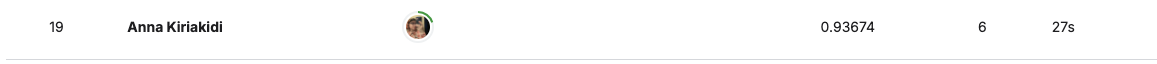